<a href="https://colab.research.google.com/github/ggm1207/PR000/blob/main/PR_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
print("tensorflow version: ", tf.__version__)
print("numpy version: ",np.__version__)
print("matplotlib version: ", matplotlib.__version__)

tensorflow version:  2.4.0
numpy version:  1.19.4
matplotlib version:  3.2.2


## Apporach

- GAN구현
- np.linspace를 사용하여 벡터 공간 탐색해보기

In [3]:
# load data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # range: [-1, 1]

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)

In [5]:
TOTAL_IMG = 60000
BATCH = 500
STEPS = TOTAL_IMG // BATCH

def prepare(images):
    images = tf.reshape(images, [BATCH, 784])
    return images

train_dataset = train_dataset.shuffle(10000).batch(BATCH).map(prepare)

In [6]:
next(iter(train_dataset)).shape

TensorShape([500, 784])

In [7]:
# Build Model

G = tf.keras.models.Sequential()
G.add(layers.Dense(256, input_shape=(100, )))
G.add(layers.BatchNormalization())
G.add(layers.LeakyReLU(0.2))

G.add(layers.Dense(512))
G.add(layers.BatchNormalization())
G.add(layers.LeakyReLU(0.2))


G.add(layers.Dense(1024))
G.add(layers.BatchNormalization())
G.add(layers.LeakyReLU(0.2))

G.add(layers.Dense(28*28, activation='tanh'))

D = tf.keras.models.Sequential()
D.add(layers.Dense(1024, input_shape=(28*28, )))
D.add(layers.LeakyReLU(0.2))
D.add(layers.Dropout(0.3))

D.add(layers.Dense(512))
D.add(layers.LeakyReLU(0.2))
D.add(layers.Dropout(0.3))

D.add(layers.Dense(256))
D.add(layers.LeakyReLU(0.2))
D.add(layers.Dropout(0.3))

D.add(layers.Dense(1, activation='sigmoid'))

In [8]:
G.summary()
D.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

In [9]:
# Optimizer and Loss

g_optim = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
d_optim = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

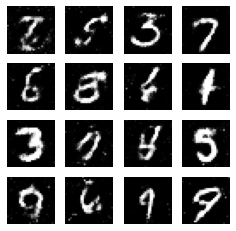

Epoch 55 ---


KeyboardInterrupt: ignored

In [10]:
# Train

EPOCHS = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH, 100])

    # training Generator, Fixed Discriminator 
    with tf.GradientTape() as gen_tape:
        g_images = G(noise, training=True)
        
        fake_output = D(g_images)
        gen_loss = generator_loss(fake_output)

    grad = gen_tape.gradient(gen_loss, G.trainable_variables)
    g_optim.apply_gradients(zip(grad, G.trainable_variables))

    with tf.GradientTape() as disc_tape:
        g_images = G(noise, training=False)

        real_output = D(images)
        fake_output = D(g_images)
        disc_loss = discriminator_loss(real_output, fake_output)

    grad = disc_tape.gradient(disc_loss, D.trainable_variables)
    d_optim.apply_gradients(zip(grad, D.trainable_variables))

def generate_images(model, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0
    predictions = tf.reshape(predictions, [-1, 28, 28])

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :]), cmap='gray')
        plt.axis("off")

    plt.show()

from IPython import display
seed = tf.random.normal([16, 100])

for EPOCH in range(EPOCHS):
    print(f"Epoch {EPOCH} ---")
    for train_images in train_dataset:
        train_step(train_images)
    
    display.clear_output(wait=True)
    generate_images(G, seed)

In [11]:
seed[0].numpy()

array([ 0.77803284,  0.8547889 , -0.68092024, -0.83783877, -0.02434368,
       -0.59363   , -1.6796231 , -0.34883994,  0.2530831 , -2.0508807 ,
       -0.16846931, -1.3511997 ,  2.1371424 ,  0.6843872 , -0.42301422,
       -0.47557592, -1.3196394 ,  0.898896  ,  0.42711654, -0.01353829,
       -0.8067725 , -0.0693315 , -0.0892809 ,  1.6026157 , -0.35738894,
        0.6081088 ,  1.4275556 ,  1.4169644 ,  0.14310952,  1.7716582 ,
        0.11870999, -0.46013847, -1.5992076 , -0.8193455 ,  0.99162185,
        1.8723022 , -1.5658958 ,  0.17228332,  0.24945529, -2.1283329 ,
       -0.4514731 ,  0.82099277, -0.17027412, -0.75274336, -0.5187955 ,
       -0.3740494 ,  0.2576098 ,  0.09611133, -0.13709186,  1.4987199 ,
        0.39927426,  0.17697856, -0.11154173,  1.7643037 ,  0.02326033,
        0.06686605,  0.9172894 ,  0.15904379,  0.8390474 ,  0.35234404,
        0.03899269,  0.3069175 , -1.6876907 ,  0.02679252,  0.9075265 ,
       -1.0608709 , -0.5967749 , -0.8330853 ,  1.2125167 ,  0.57

In [ ]:
np.linespace()

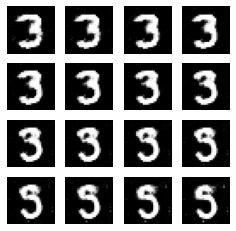

In [12]:
def explore_between_two_vectors(s_vector, e_vector):
    seeds = np.linspace(s_vector, e_vector, 16)
    seeds = tf.convert_to_tensor(seeds, dtype=tf.float32)
    generate_images(G, seeds)

s_vector = seed[8].numpy()
e_vector = seed[11].numpy()

explore_between_two_vectors(s_vector, e_vector)  # 3 ~ 5

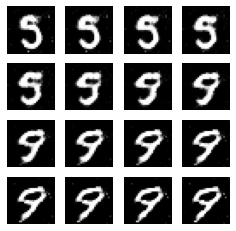

In [13]:
s_vector = seed[11].numpy()
e_vector = seed[15].numpy()

explore_between_two_vectors(s_vector, e_vector)

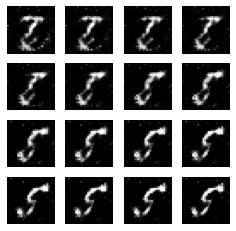

In [14]:
s_vector = seed[0].numpy()
e_vector = seed[1].numpy()

explore_between_two_vectors(s_vector, e_vector)

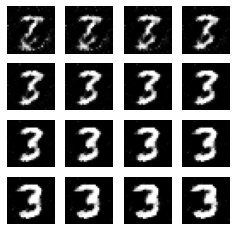

In [15]:
s_vector = seed[0].numpy()
e_vector = seed[8].numpy()

explore_between_two_vectors(s_vector, e_vector)

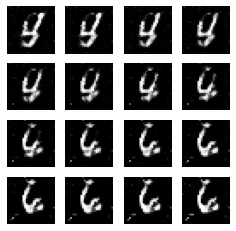

In [16]:
s_vector = seed[10].numpy()
e_vector = seed[13].numpy()

explore_between_two_vectors(s_vector, e_vector)